## Monte Carlo control -- simple example
This notebook provides a working example of Monte Carlo control using a simple OpenAI maze task.

### Setup
Here we load the required modules as well as some other standard ones that might be needed. The 'autoreload' command makes it so that external modules are re-loaded when used. This makes it easy to prototype modules.

In [7]:
# Setup environment and import standard modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import OpenAI Gym
import gym
print('Open AI Gym version: {}'.format(gym.__version__))

# Autoreload (see https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html)
%load_ext autoreload
%autoreload

Open AI Gym version: 0.15.4
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Test the frozen lake environment
We'll start with a simple 4 x 4 frozen lake environment.  The goal here is to move from the starting point to the goal without falling into a hole.  Note that here the environment is the same every time (i.e., the 'holes' are in the same place), but the state transitions are probabilistic (meaning that you might not always transition to the desired state for a given action).

In [8]:
# Note that it is possible to turn the randomness on/off using the 'is_slippery' argument (True by default)
env = gym.make('FrozenLake-v0', is_slippery=False)
env.reset()
max_steps = 100
env.render()  # Render initial state
for t in range(max_steps):
    action = env.action_space.sample()  # Sample a random action
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        print('Episode finished after {} timesteps (Reward: {})'.format(t+1, reward))
        break
env.close()


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Episode finished after 15 timesteps (Reward: 0.0)


### Investigate the environment
In order to set up the model, we need to know the size of the action space (the number of possible actions that can be taken), as well as the size of the observation space (the number of possible states in the environment).

In [3]:
# Get action and observation space
print('Action space: {}'.format(env.action_space))
print('Observation space: {}'.format(env.observation_space))
# Generate a sample action and observation
print('Sample action: {}'.format(env.action_space.sample()))
print('Observation: {}'.format(obs))

Action space: Discrete(4)
Observation space: Discrete(16)
Sample action: 3
Observation: 5


This tells us that there are 4 possible action values (0-3), and 16 possible observation states (0-15).  This allows us to determine the size of the action-value space.

### On-policy first-visit Monte Carlo (MC) control
The central idea behind MC control is to estimate the value of each action by sampling the environment. At the end of each episode, we calculate the return for each state visited and use these values to update the action values $Q(S_t, A_t)$ for each state. We'll use an $\epsilon$-greedy policy where we take the action with the maximum value with probability $(1-\epsilon)$ and select an action at random with probability $\epsilon$. This will ensure that the agent continues to explore during the learning process.

In [10]:
# Setup parameters -- control
eps = 0.2  # Probability of selecting a random action
gam = .95  # Reward discounting (gamma)

# Setup parameters -- number of episodes
episodes = 10000  # Number of episodes
update_block = int(episodes/20)  # How often to display update messages

# Create environment and get size/shape
# Note: for testing purposes, pass the argument 'is_slippery=False'
env = gym.make('FrozenLake-v0', is_slippery=True)
n_actions = env.action_space.n
n_states = env.observation_space.n

# Initialize matrices used for control
P = np.ones([n_states, n_actions]) / n_actions  # Policy (initialize to equal probability)
Q = np.zeros([n_states, n_actions])  # Action values
C = np.zeros([n_states, n_actions])  # Observation counter (used for computing value)

# Initialize performance metrics
episode_steps = np.zeros(episodes)  # Number of steps each episode
episode_reward = np.zeros(episodes)  # Reward for each episode
max_episode_steps = 1000  # Maximum number of steps per episode

# Iterate over episodes
env.reset()
for i in range(episodes):
    # Initialize state/action/reward and environment
    R = np.zeros(max_episode_steps)
    S = np.zeros(max_episode_steps, dtype=int)
    A = np.zeros(max_episode_steps, dtype=int)

    # Generate an episode
    S[0] = env.reset()
    for t in range(max_episode_steps):
        # Sample the action and step
        action = np.random.choice(range(n_actions), p=P[S[t], :])
        obs, reward, done, info = env.step(action)

        # Record outcome of action.  Note that the reward and new observation
        # are associated with the *next* step
        A[t] = action
        R[t+1] = reward
        S[t+1] = obs

        # Check for end of episode
        if done:
            # Truncate matrices
            A = A[0:t+2]
            R = R[0:t+2]
            S = S[0:t+2]
            episode_steps[i] = t + 1
            episode_reward[i] = reward
            break
    
    # Update action-value and policy
    T = t+1  # Number of time steps
    G = 0
    
    # Step backwards through the episode, starting at T-1
    for t in range(T-1, -1, -1):
        # Compute discounted reward (return)
        G = gam * G + R[t+1]

        # Get state-action value
        s = S[t]
        a = A[t]

        # Update value function if this is the first visit to (s, a)
        if (s, a) not in zip(S[0:t-1], A[0:t-1]):
            # Update action-value matrix
            Q[s, a] = (Q[s, a] * C[s, a] + G)/(C[s, a] + 1)
            C[s, a] += 1

            # Update policy
            mask = np.arange(n_actions) == np.argmax(Q[s, :])
            P[s, mask] = 1 - eps + (eps/n_actions)
            P[s, ~mask] = eps/n_actions

    # Display update message
    if ((i+1) % update_block) == 0:
        reward_rate = sum(episode_reward[i - update_block + 1:i+1])/update_block
        print('Episode {} finished: Reward rate = {}'.format(i+1, reward_rate))

# Cleanup
env.close()

Episode 500 finished: Reward rate = 0.0
Episode 1000 finished: Reward rate = 0.024
Episode 1500 finished: Reward rate = 0.056
Episode 2000 finished: Reward rate = 0.048
Episode 2500 finished: Reward rate = 0.056
Episode 3000 finished: Reward rate = 0.058
Episode 3500 finished: Reward rate = 0.082
Episode 4000 finished: Reward rate = 0.068
Episode 4500 finished: Reward rate = 0.062
Episode 5000 finished: Reward rate = 0.064
Episode 5500 finished: Reward rate = 0.088
Episode 6000 finished: Reward rate = 0.142
Episode 6500 finished: Reward rate = 0.112
Episode 7000 finished: Reward rate = 0.136
Episode 7500 finished: Reward rate = 0.118
Episode 8000 finished: Reward rate = 0.114
Episode 8500 finished: Reward rate = 0.144
Episode 9000 finished: Reward rate = 0.114
Episode 9500 finished: Reward rate = 0.112
Episode 10000 finished: Reward rate = 0.156


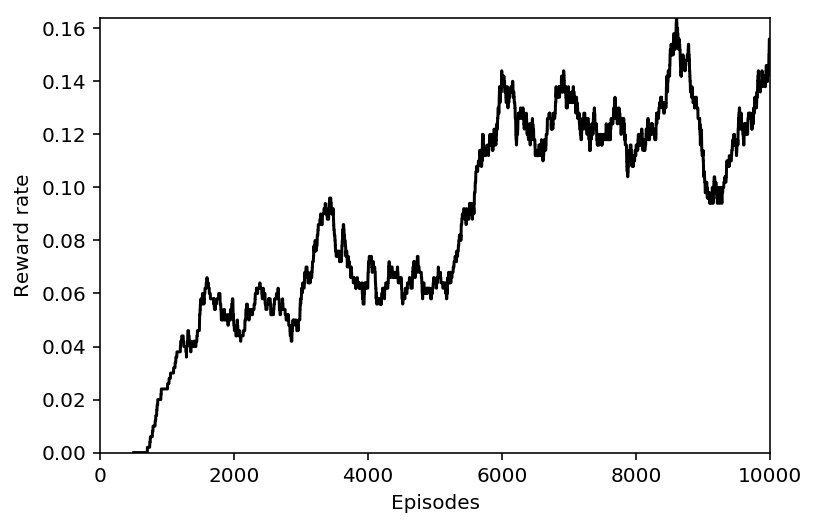

In [11]:
# Plot results

# Calculate reward rate as the running average over a the number of trials specified by update_block
reward_rate = np.convolve(episode_reward, np.ones(update_block), mode='valid')/update_block
episode_number = np.arange(update_block, episodes+1)

# Plot reward rate vs episodes
plt.plot(episode_number, reward_rate, color='k')
plt.ylabel('Reward rate')
plt.xlabel('Episodes')
plt.xlim(0, episodes)
plt.ylim(0, np.max(reward_rate))
plt.show()

### Results
It appears that the amount of learning that is observed is very dependent on whether or not a reward is encountered early on. In general, $\gamma$ values close to 1 and $\epsilon$ values around 0.2 seem to do best, resulting in a reward rate that asymptotes around 0.2 over 10000 trials. It is important to point out that the environment is quite stochastic, though. Turning this off causes the reward rate to jump dramatically, though how quickly this happens is dependent on randomly encountering a reward.

A number of tweaks could potentially be used to improve performance. Some of these include:
- Scheduling $\epsilon$ to decrease with time (transition from exploration to exploitation)
- Moving away from using a true average. Some sort of moving average that forgets old returns would likely help.